In [1]:
import pennylane as qml
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
def abs_error(m1, m2):
    return abs(m1 - m2)


def relative_error(m1, m2):
    return abs_error(m1, m2) / abs(m1)


def mse(m1, m2):
    return (m2 - m1) ** 2


def print_data(name, mean, true_mean, samples__):
    return {
        "Name": name,
        "Mean": mean,
        "Absolute Error": abs_error(true_mean, mean),
        "Relative Error": relative_error(true_mean, mean),
        "MSE": mse(true_mean, mean),
        "Samples": samples__,
    }

In [3]:
def func_f(x):
    return np.sin(x) ** 2


true_mean = math.sinh(1) / math.exp(1)


def mc_mean(numSamples):
    sampleData: list = np.random.randn(numSamples, 1)
    values: list = func_f(sampleData)
    MCMean: float = np.mean(values)
    return print_data("MC Mean", MCMean, true_mean, numSamples)

In [4]:
mse_values = []
abs_values = []
num_samples = []
data = []
variances = []

for i in range(5):
    samples_ = 10**i
    num_samples.append(samples_)
    answer = mc_mean(samples_)

    results = []
    for _ in range(5):
        result = mc_mean(samples_)
        results.append(result["Mean"])
    variance = np.var(results)

    answer["Variance"] = variance

    data.append(answer)
    mse_values.append(answer.get("MSE"))
    abs_values.append(answer.get("Absolute Error"))

In [5]:
df = pd.DataFrame(data)
print(df)
# print(df.to_latex(index=False, float_format="%.4f"))

      Name      Mean  Absolute Error  Relative Error       MSE  Samples  \
0  MC Mean  0.509632        0.077300        0.178797  0.005975        1   
1  MC Mean  0.187163        0.245169        0.567085  0.060108       10   
2  MC Mean  0.406376        0.025956        0.060038  0.000674      100   
3  MC Mean  0.428482        0.003850        0.008906  0.000015     1000   
4  MC Mean  0.436291        0.003959        0.009158  0.000016    10000   

   Variance  
0  0.059543  
1  0.003943  
2  0.000182  
3  0.000132  
4  0.000005  


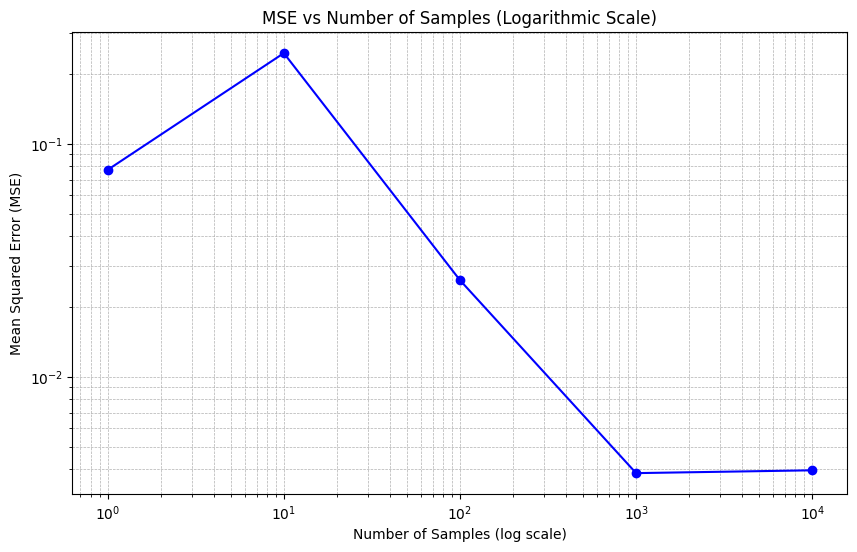

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(num_samples, abs_values, marker="o", linestyle="-", color="b")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Samples (log scale)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Number of Samples (Logarithmic Scale)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [7]:
# TODO Quantum Amplitude Estimation

In [8]:
m = 5
M = 2**m
xmax = np.pi  # bound to region [-pi, pi]
xs = np.linspace(-xmax, xmax, M)

probs = np.array([norm().pdf(x) for x in xs])
probs /= np.sum(probs)

In [9]:
def func(i):
    return np.sin(xs[i]) ** 2


mse_values = []
num_samples = []
data = []
for n in range(1, 6):
    num_samples.append(2**n)
    N = 2**n

    target_wires = range(m + 1)
    estimation_wires = range(m + 1, n + m + 1)

    dev = qml.device("default.qubit", wires=(n + m + 1))

    @qml.qnode(dev)
    def circuit():
        qml.templates.QuantumMonteCarlo(
            probs,
            func,
            target_wires=target_wires,
            estimation_wires=estimation_wires,
        )
        return qml.probs(estimation_wires)

    results = []
    for _ in range(4, 17):
        qmc_probs = circuit()
        phase_estimated = np.argmax(circuit()[: int(N / 2)]) / N
        answer = (1 - np.cos(np.pi * phase_estimated)) / 2
        results.append(answer)
    variance = np.var(results)
    answer = np.mean(results)

    format_data = print_data("QMC", answer, true_mean, 2**n)
    format_data["Variance"] = variance

    mse_values.append(format_data.get("MSE"))
    data.append(format_data)

In [10]:
df = pd.DataFrame(data)
print(df)

  Name      Mean  Absolute Error  Relative Error       MSE  Samples  \
0  QMC  0.000000        0.432332        1.000000  0.186911        2   
1  QMC  0.146447        0.285886        0.661264  0.081731        4   
2  QMC  0.308658        0.123674        0.286062  0.015295        8   
3  QMC  0.402455        0.029878        0.069108  0.000893       16   
4  QMC  0.450991        0.018659        0.043159  0.000348       32   

       Variance  
0  0.000000e+00  
1  7.703720e-34  
2  3.081488e-33  
3  3.081488e-33  
4  1.232595e-32  


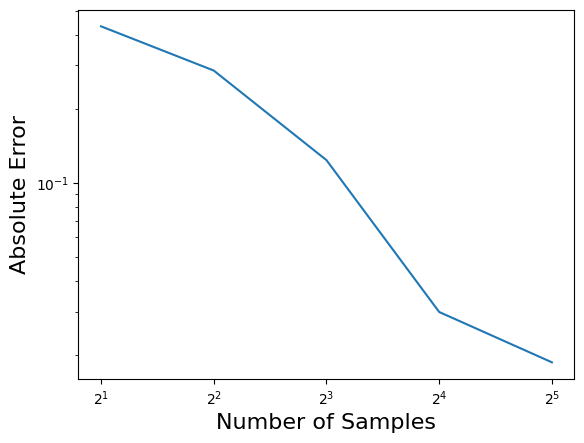

In [11]:
abs_error = df["Absolute Error"].to_list()
samples_numbers = df["Samples"].to_list()


plt.plot(samples_numbers, abs_error)
plt.xlabel("Number of Samples", fontsize=16)
plt.ylabel("Absolute Error", fontsize=16)
plt.xscale("log", base=2)
plt.yscale("log")